In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, solve

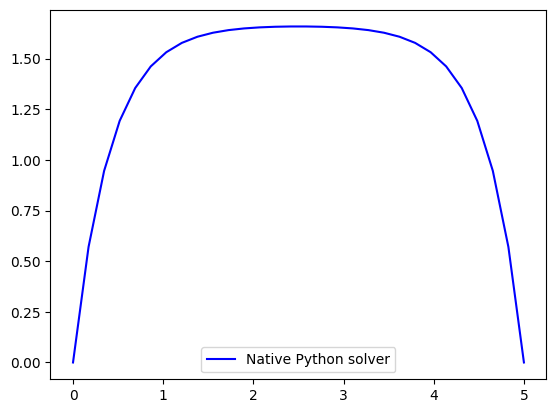

In [4]:
def Source(x):
 return 5

#Specify these parameters
a = 5
D_coef = 0.5
Sigma_a = 3
n = 30

#Intermediary parameters to keep things tidy
delta = a/(n-1)
x = np.linspace(delta, a-delta, n-2)
phi = []
S = []

#Create source vector
for i in x:
 value = Source(i) 
 S.append(value)


#Create your main matrix A, in this case it's a tridiagonal matrix. You can create each of the diagonal separately using the np.diag() function 
#and then add them all together
d = []
u = []
l = []

for i in np.arange(1, n-1):
 element = Sigma_a+2*D_coef/delta**2
 d.append(element)
for i in np.arange(1, n-2):
 element = -D_coef/delta**2
 u.append(element)
for i in np.arange(1, n-2):
 element = -D_coef/delta**2
 l.append(element)

D = np.diag(d, 0)
U = np.diag(u, 1)
L = np.diag(l, -1)

A = D+U+L

#The solution to A phi = S
phi = np.linalg.solve(A,S)

#Impose Boundary conditions by simply adding them in the front/at the end, this means u have to alter ur x-values so the sizes match
xm = np.linspace(0, a, n)              
Sol = np.concatenate([[0], phi, [0]]) 

#Post-processing
plt.plot(xm, Sol, color='b', label='Native Python solver')
plt.legend()
plt.show()


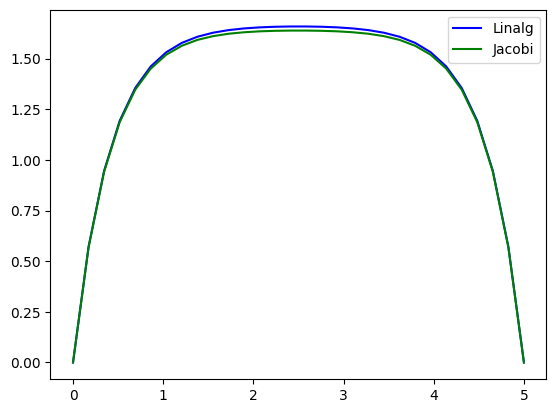

It took 39 iterations to converge


In [21]:
#Jacobi-Richardson method
#Although not explicitly asked of us, we will first apply the Point-Jacobi method as it is the simplest to write down and serves as a 
#building block for more complicated iterative algorithms.
#We'll largely copy the algorithm above, but add the necessary ingredients + change variables' name whenever needed so we're clear on which var 
#represents what 
def Source(x):
 return 5

#Specify these parameters
a = 5
D_coef = 0.5
Sigma_a = 3
n = 30
Desired_error = 0.001

#Intermediary parameters to keep things tidy
delta = a/(n-1)
x = np.linspace(delta, a-delta, n-2)
phi = []
S = []
error = 10
phi_0 = [1]*(n-2) #we will use this as an initial guess, since our problem A phi = S (with A well-behaved) means that it will converge regardless
iteration = 0                  #of your initial guess, the only thing that will change is how fast it will converge

#Create source vector
for i in x:
 value = Source(i) 
 S.append(value)

#Create your main matrix A, in this case it's a tridiagonal matrix. You can create each of the diagonal separately using the np.diag() function 
#and then add them all together
d = []
u = []
l = []

for i in np.arange(1, n-1):
 element = Sigma_a+2*D_coef/delta**2
 d.append(element)
for i in np.arange(1, n-2):
 element = -D_coef/delta**2
 u.append(element)
for i in np.arange(1, n-2):
 element = -D_coef/delta**2
 l.append(element)

D = np.diag(d, 0)
U = np.diag(u, 1)
L = np.diag(l, -1)

A = D+U+L

#Decomposition of A = D - B, we'll immediately construct D^(-1) = Di by simply flipping the diagonal elements
di = []

for i in np.arange(1, n-1):
 element = 1/(Sigma_a+2*D_coef/delta**2)
 di.append(element)

Di = np.diag(di, 0)

B = D-A

error = 10
while error > Desired_error :
    phi_i = Di@B@phi_0 + Di@S
    error = np.linalg.norm(phi_i-phi_0)/np.linalg.norm(phi_i)
    phi_0 = phi_i
    iteration += 1

#The solution to A phi = S
phi = np.linalg.solve(A,S)

#Impose Boundary conditions by simply adding them in the front and at the end of the flux vector, this also means u have to alter ur x values so the sizes match
xm = np.linspace(0, a, n)              
Sol = np.concatenate([[0], phi, [0]]) 
Sol2 = np.concatenate([[0], phi_0, [0]]) 

#Post-processing
plt.plot(xm, Sol, color='b', label='Linalg')
plt.plot(xm, Sol2, color='g', label='Jacobi')
plt.legend()
plt.show()
print("It took", iteration, "iterations to converge")

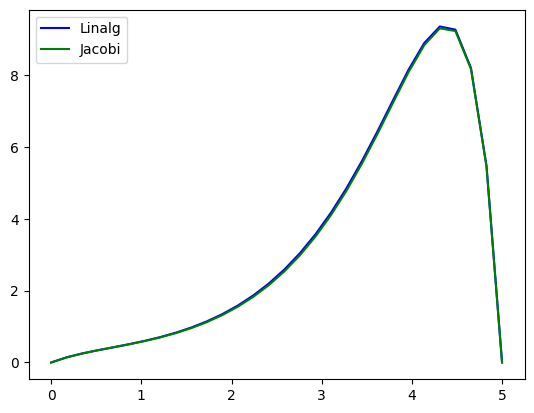

It took 44 iterations to converge


In [18]:
#Jacobi-Richardson method but the elementwise operations are explicitly written out -> will make SOR implementation easier
def Source(x):
 return np.cosh(x)

#Specify these parameters
a = 5
D_coef = 0.5
Sigma_a = 3
n = 30
Desired_error = 0.001

#Intermediary parameters to keep things tidy
delta = a/(n-1)
x = np.linspace(delta, a-delta, n-2)
phi = []
S = []
error = 10
phi_0 = [1]*(n-2) #we will use this as an initial guess, since our problem A phi = S (with A well-behaved) means that it will converge regardless
                  #of your initial guess, the only thing that will change is how fast it will converge

#Create source vector
for i in x:
 value = Source(i) 
 S.append(value)

#Create your main matrix A, in this case it's a tridiagonal matrix. You can create each of the diagonal separately using the np.diag() function 
#and then add them all together
d = []
u = []
l = []

for i in np.arange(1, n-1):
 element = Sigma_a+2*D_coef/delta**2
 d.append(element)
for i in np.arange(1, n-2):
 element = -D_coef/delta**2
 u.append(element)
for i in np.arange(1, n-2):
 element = -D_coef/delta**2
 l.append(element)

D = np.diag(d, 0)
U = np.diag(u, 1)
L = np.diag(l, -1)

A = D+U+L

#Decomposition of A = D - B, we'll immediately construct D^(-1) = Di by simply flipping the diagonal elements
di = []

for i in np.arange(1, n-1):
 element = 1/(Sigma_a+2*D_coef/delta**2)
 di.append(element)

Di = np.diag(di, 0)
B = D-A

rows = np.arange(0,n-2)
columns = np.arange(0,n-2)
error = 10
iteration = 0
while error > Desired_error:
    phi_new = np.zeros(n-2)
    for i in rows:
      for j in columns:       
       su = sum(A[i][j]*phi_0[j] for j in columns)
       phi_new[i]= 1/A[i][i]*(S[i]-su+A[i][i]*phi_0[i])    
    error = np.linalg.norm(phi_new-phi_0)/np.linalg.norm(phi_new)
    phi_0 = phi_new
    iteration = iteration + 1

#The solution to A phi = S
phi = np.linalg.solve(A,S)

#Impose Boundary conditions by simply adding them in the front and at the end of the flux vector, this also means u have to alter ur x values so the sizes match
xm = np.linspace(0, a, n)              
Sol = np.concatenate([[0], phi, [0]]) 
Sol2 = np.concatenate([[0], phi_0, [0]]) 

#Post-processing
plt.plot(xm, Sol, color='b', label='Linalg')
plt.plot(xm, Sol2, color='g', label='Jacobi')
plt.legend()
plt.show()
print("It took", iteration ,"iterations to converge")

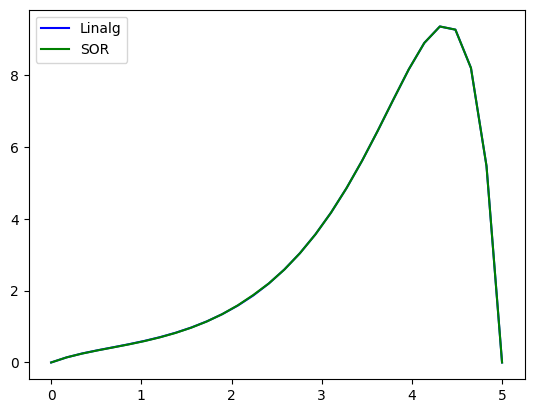

It took 16 iterations to converge


In [20]:
#Jacobi-Richardson method but the elementwise operations are explicitly written out -> will make SOR implementation easier
#Define source function
def Source(x):
 return np.cosh(x)

#Specify these parameters
a = 5
D_coef = 0.5
Sigma_a = 3
n = 30
Desired_error = 0.001
omega = 1.5

#Intermediary parameters to keep things tidy
delta = a/(n-1)
x = np.linspace(delta, a-delta, n-2)
phi = []
error = 10
S = []
phi_0 = np.ones(n-2) #we will use this as an initial guess, since our problem A phi = S (with A well-behaved) means that it will converge regardless
                  #of your initial guess, the only thing that will change is how fast it will converge

#Create source vector
for i in x:
 value = Source(i) 
 S.append(value)

#Create your main matrix A, in this case it's a tridiagonal matrix. You can create each of the diagonal separately using the np.diag() function 
#and then add them all together
d = []
u = []
l = []

for i in np.arange(1, n-1):
 element = Sigma_a+2*D_coef/delta**2
 d.append(element)
for i in np.arange(1, n-2):
 element = -D_coef/delta**2
 u.append(element)
for i in np.arange(1, n-2):
 element = -D_coef/delta**2
 l.append(element)

D = np.diag(d, 0)
U = np.diag(u, 1)
L = np.diag(l, -1)

A = D+U+L

#Decomposition of A = D - B, we'll immediately construct D^(-1) = Di by simply flipping the diagonal elements
di = []

for i in np.arange(1, n-1):
 element = 1/(Sigma_a+2*D_coef/delta**2)
 di.append(element)

Di = np.diag(di, 0)
B = D-A

#Actual method, watch out for indices
rows = np.arange(0,n-2)
columns = np.arange(0,n-2)
error = 10
iteration = 0
phi_guess = np.zeros(n-2)
while error > Desired_error:
    phi_new = phi_0.copy()
    for i in rows:
        if i == n-3:
            phi_guess[i]=1/A[i][i]*(S[i]-A[i][i-1]*phi_new[i-1])
            phi_new[i] = omega*phi_guess[i]+(1-omega)*phi_0[i]
        else:
          su = np.sum(A[i, 0:i] * phi_new[0:i]) + np.sum(A[i, i+1:] * phi_0[i+1:])
          phi_guess[i]= 1/A[i][i]*(S[i]-su) 
          phi_new[i] = omega*phi_guess[i]+(1-omega)*phi_0[i]
    error = np.linalg.norm(phi_new-phi_0)/np.linalg.norm(phi_new)
    phi_0 = phi_new.copy()
    iteration = iteration + 1

#The solution to A phi = S
phi = np.linalg.solve(A,S)

#Impose Boundary conditions by simply adding them in the front and at the end of the flux vector, this also means u have to alter ur x values so the sizes match
xm = np.linspace(0, a, n)              
Sol = np.concatenate([[0], phi, [0]]) 
Sol2 = np.concatenate([[0], phi_0, [0]]) 

#Post-processing
plt.plot(xm, Sol, color='b', label='Linalg')
plt.plot(xm, Sol2, color='g', label='SOR')
plt.legend()
plt.show()
print("It took", iteration ,"iterations to converge")